`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   





# Работа с временным рядом

### Работу выполнила Пашнина Алёна

### Подключаем необходимые молули и загружаем данные

In [ ]:
import yfinance as yf

import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pandas.core.nanops import nanmean as pd_nanmean

import tqdm
from tqdm.auto import tqdm

import seaborn as sns
sns.set_theme()

from math import sqrt
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
df = yf.Ticker('600519.SS').history(interval = "1d", start = '2012-01-01')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-04 00:00:00+08:00,129.304791,130.162325,124.915854,125.098167,4099271,0.0,0.0
2012-01-05 00:00:00+08:00,124.240659,125.050920,123.133293,123.666718,3644839,0.0,0.0
2012-01-06 00:00:00+08:00,123.632935,126.975280,122.653863,126.023224,3048065,0.0,0.0
2012-01-09 00:00:00+08:00,125.591101,127.002306,122.734919,126.948288,3165379,0.0,0.0
2012-01-10 00:00:00+08:00,126.266296,131.438491,125.665352,131.316940,4747507,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-27 00:00:00+08:00,1748.000000,1770.000000,1730.000000,1757.920044,2560504,0.0,0.0
2023-04-28 00:00:00+08:00,1763.010010,1782.770020,1753.969971,1760.520020,2622464,0.0,0.0
2023-05-04 00:00:00+08:00,1769.000000,1777.670044,1736.000000,1749.900024,2746642,0.0,0.0


Нам нужны только данные о дате и цене закрытия.

In [ ]:
df = df[['Close']]
df

,Close
Date,
2012-01-04 00:00:00+08:00,125.098167
2012-01-05 00:00:00+08:00,123.666718
2012-01-06 00:00:00+08:00,126.023224
2012-01-09 00:00:00+08:00,126.948288
2012-01-10 00:00:00+08:00,131.316940
...,...
2023-04-27 00:00:00+08:00,1757.920044
2023-04-28 00:00:00+08:00,1760.520020
2023-05-04 00:00:00+08:00,1749.900024


### Строим график временного ряда

<Axes: title={'center': 'Цена на момент закрытия на акции компании'}, xlabel='Date'>

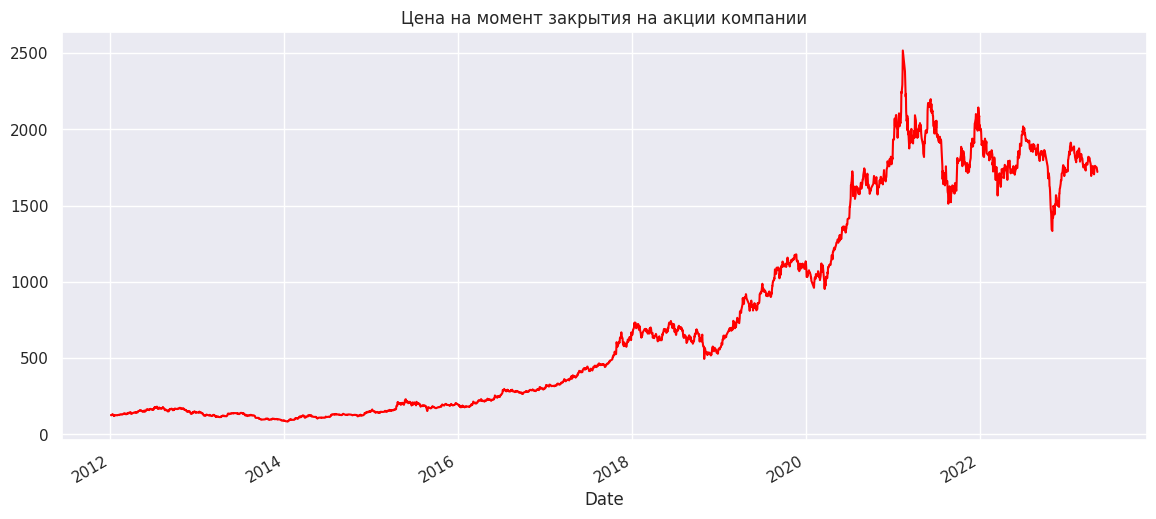

In [ ]:
df.Close.plot( figsize=(14,6),title= 'Цена на момент закрытия на акции компании', fontsize=11, color="red")

График показывает, что цены на акции были в основном стабильны в начале периода. Однако, можно заметить, что существует большое количество короткосрочных колебаний цен, которые не подчиняются общему тренду и вызваны внешними факторами.

На графике цен на момент закрытия акций, представленном выше, можно наблюдать общий тренд цен на протяжении всего периода.

### Тест Дикки-Фуллера на стационарность
Проверим на уровне значимости 0.05

In [ ]:
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 4))
    orig = plt.plot(timeseries, color='green',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    # p-value
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [ ]:
sample_data = df.Close

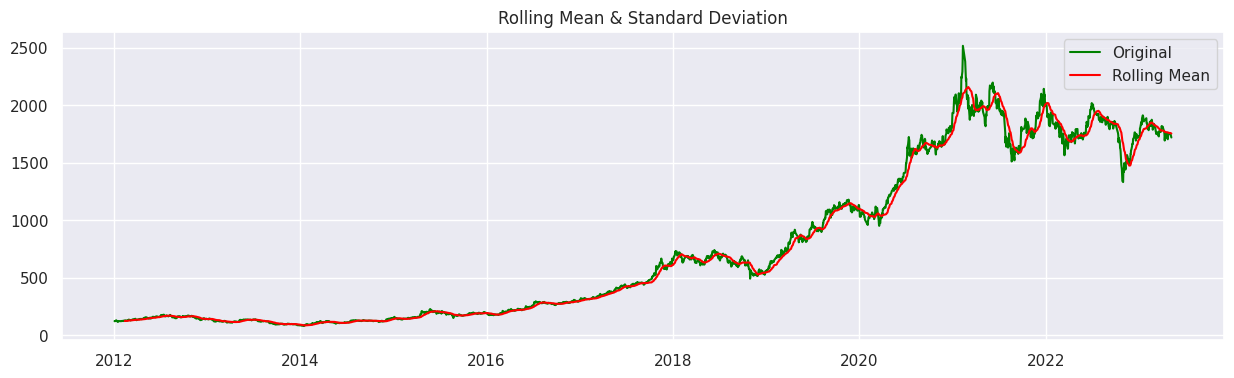

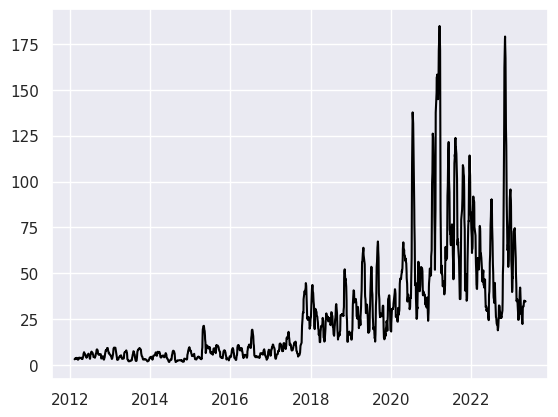

Results of Dickey-Fuller Test:
p-value = 0.9044. The series is likely non-stationary.
Test Statistic                   -0.432966
p-value                           0.904447
#Lags Used                       28.000000
Number of Observations Used    2723.000000
Critical Value (1%)              -3.432754
Critical Value (5%)              -2.862602
Critical Value (10%)             -2.567335
dtype: float64


In [ ]:
test_stationarity(sample_data)

На основании теста Dickey-Fuller, можно сделать вывод о том, что временной ряд не является стационарным. Это подтверждается большим значением p-value, превышающим уровень значимости 0.05, а также недостаточным значением тестовой статистики для отклонения от нулевой гипотезы о нестационарности ряда.

### Методология Бокса-Дженкинса

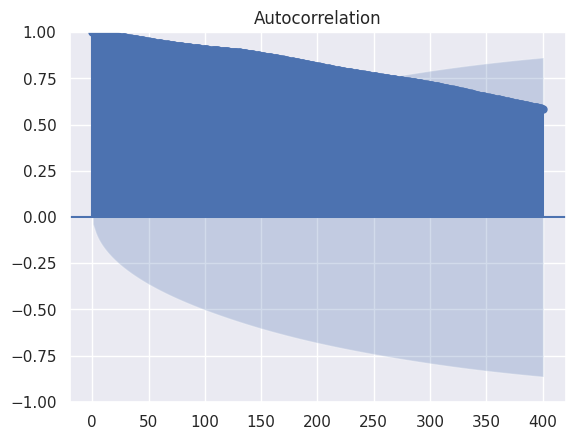

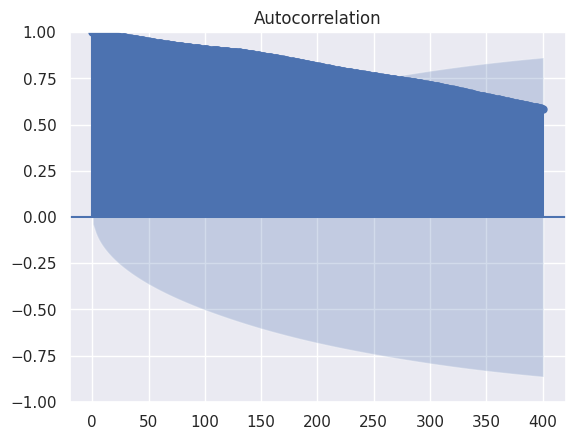

In [ ]:
plot_acf(df.Close, lags=400)

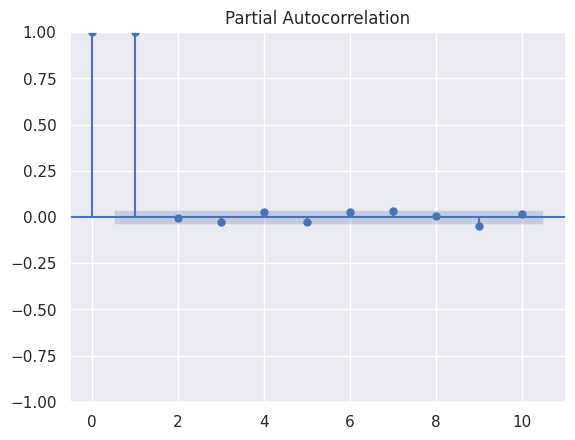

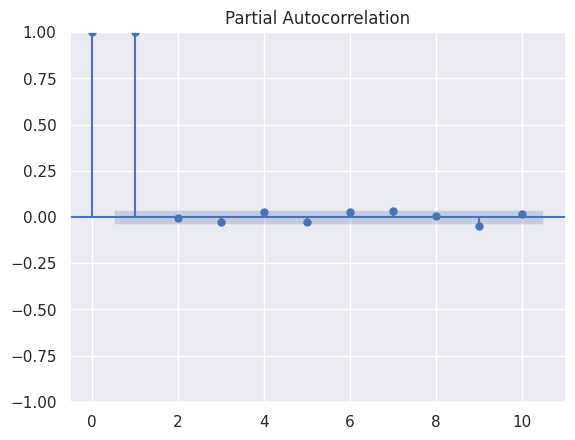

In [ ]:
plot_pacf(df.Close, lags=10)

Это означает, что на 270-м лаге автокорреляционная функция (ACF) последующие лаги становятся значимыми. Из графика PACF можно сделать вывод, что после 2-го лага все последующие лаги не являются значимыми, т.е. корреляция становится незначительной.

Результаты построение PACF и ACF не удовлетворительны. Сложно определить примерные значения p,q для построения ARIMA-модели. Предлагается для начала избавится от трендовой зависимости

### Удалениe линейной трендовой составляющей из временного ряда

In [ ]:
df["index"] = range(1, len(df)+1, 1)

In [ ]:
from sklearn.linear_model import LinearRegression

X = np.array(df["index"]).reshape((-1, 1))
Y = np.array(df["Close"])

model = LinearRegression().fit(X,Y)
print('Y =', model.coef_[0], '* X +', model.intercept_)
print('coefficient of determination:', model.score(X, Y))

Y = 0.7845968356093289 * X + -328.1258251941115
coefficient of determination: 0.8400398056649622


In [ ]:
df["Close_t"] = df["Close"] - (df["index"] * model.coef_[0] + model.intercept_)
df

,Close,index,Close_t
Date,,,
2012-01-04 00:00:00+08:00,125.098167,1,452.439396
2012-01-05 00:00:00+08:00,123.666718,2,450.223349
2012-01-06 00:00:00+08:00,126.023224,3,451.795259
2012-01-09 00:00:00+08:00,126.948288,4,451.935726
2012-01-10 00:00:00+08:00,131.316940,5,455.519781
...,...,...,...
2023-04-27 00:00:00+08:00,1757.920044,2748,-70.026235
2023-04-28 00:00:00+08:00,1760.520020,2749,-68.210856
2023-05-04 00:00:00+08:00,1749.900024,2750,-79.615448


<Axes: title={'center': 'Без тренда'}, xlabel='Date'>

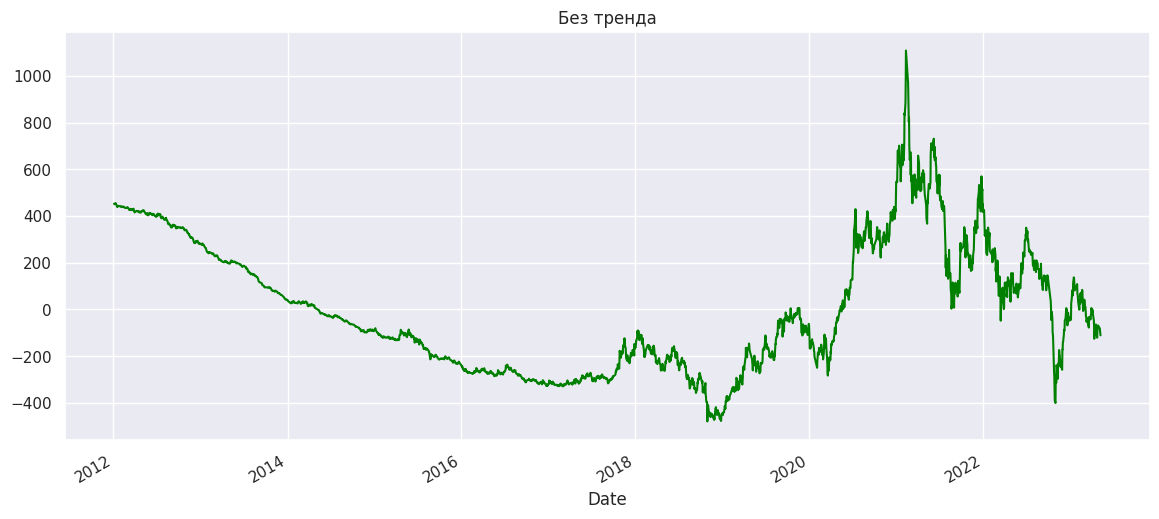

In [ ]:
df.Close_t.plot( figsize=(14,6),title= 'Без тренда', fontsize=11, color="green")

### Тест Дикки-Фуллера без тренда

In [ ]:
dftest_t = adfuller(df.Close_t,autolag='AIC')

if dftest_t[1] < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % dftest_t[1])
else:
    print('p-value = %.4f. The series is likely non-stationary.' % dftest_t[1])

p-value = 0.1708. The series is likely non-stationary.


Хоть ряд и не является стационарным, результаты теста Дики-Фуллера показывают, что значение p-value уменьшилось. Это может свидетельствовать о том, что ряд стал более стационарным, чем раньше.

### Методология Бокса-Дженкинса без тренда

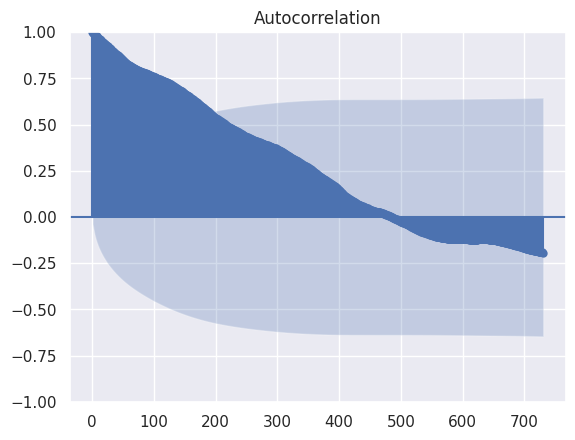

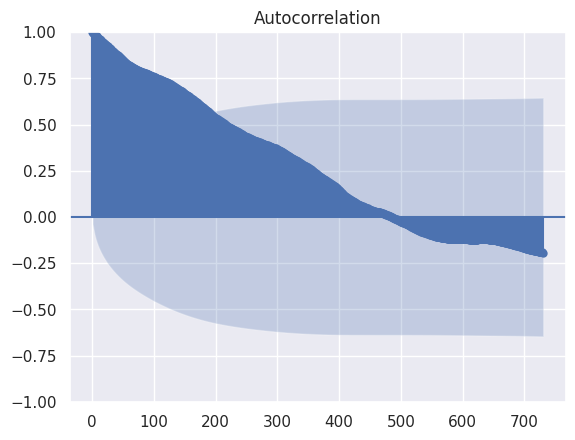

In [ ]:
plot_acf(df.Close_t, lags=730)

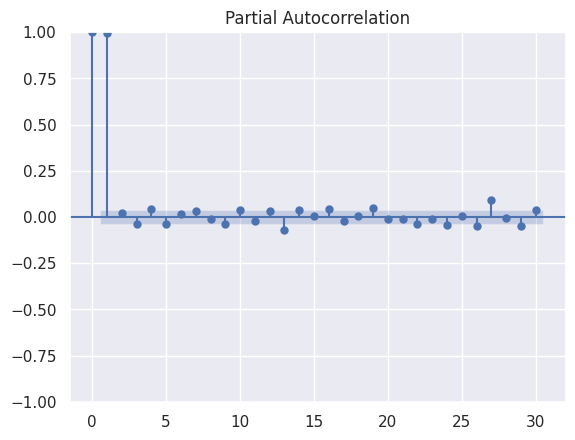

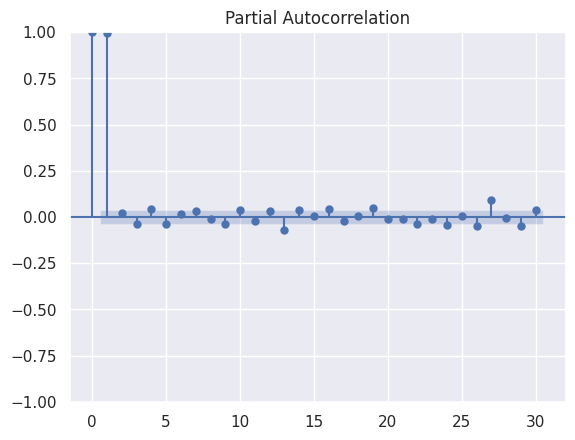

In [ ]:
plot_pacf(df.Close_t, lags=30)

Мы смогли снизить зависимость цены акции от предыдущих значений, однако она все еще остается существенной.

## Разделим данные

In [ ]:
from sklearn. model_selection import train_test_split

train, test = df[0:325], df[325:]
print(train.shape, test.shape)
test

(325, 3) (2427, 3)


,Close,index,Close_t
Date,,,
2013-05-14 00:00:00+08:00,131.121658,326,203.468915
2013-05-15 00:00:00+08:00,133.501450,327,205.064110
2013-05-16 00:00:00+08:00,133.631744,328,204.409807
2013-05-17 00:00:00+08:00,134.358719,329,204.352185
2013-05-20 00:00:00+08:00,133.734634,330,202.943504
...,...,...,...
2023-04-27 00:00:00+08:00,1757.920044,2748,-70.026235
2023-04-28 00:00:00+08:00,1760.520020,2749,-68.210856
2023-05-04 00:00:00+08:00,1749.900024,2750,-79.615448


In [ ]:
p = range(0,8)
d = range(0,3)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MAE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close_t, order = params)
    result_test = model_test.fit()
    if result_test.mae < best_MAE:
        best_params = params
        best_MAE = result_test.mae
print(best_params, best_MAE)

  0%|          | 0/240 [00:00<?, ?it/s]

(7, 0, 6) 2.4601686875503423


Таким образом на преобразованных данных можно построить модель ARIMA(7,0,6)

In [ ]:
p = range(0,8)
d = range(0,3)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MAE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train.Close, order = params)
    result_test = model_test.fit()
    if result_test.mae < best_MAE:
        best_params = params
        best_MAE = result_test.mae
print(best_params, best_MAE)

  0%|          | 0/240 [00:00<?, ?it/s]

(7, 2, 9) inf


Таким образом на исходных данных можно построить модель ARIMA(7,2,9). Даёт лучшие результаты

## Проверим модель на тестовой выборке

In [ ]:
test.Close

Date
2013-05-14 00:00:00+08:00     131.121658
2013-05-15 00:00:00+08:00     133.501450
2013-05-16 00:00:00+08:00     133.631744
2013-05-17 00:00:00+08:00     134.358719
2013-05-20 00:00:00+08:00     133.734634
                                ...     
2023-04-27 00:00:00+08:00    1757.920044
2023-04-28 00:00:00+08:00    1760.520020
2023-05-04 00:00:00+08:00    1749.900024
2023-05-05 00:00:00+08:00    1750.000000
2023-05-08 00:00:00+08:00    1720.520020
Name: Close, Length: 2427, dtype: float64

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
model_test = sm.tsa.arima.ARIMA(test.Close, order = (2,1,4))
result_test = model_test.fit()
preds = result_test.predict(dynamic=False)

mean_absolute_percentage_error(test.Close, preds)

1.480645729945817

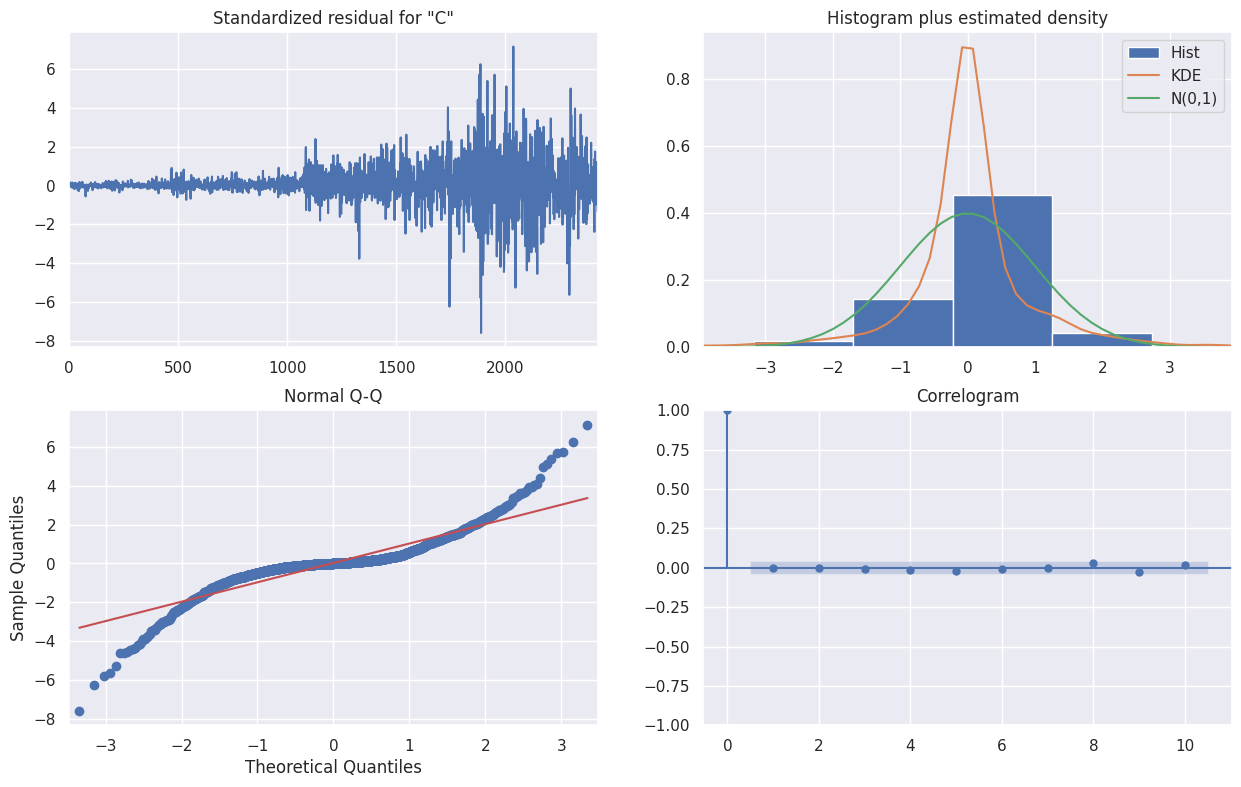

In [ ]:
result_test.plot_diagnostics(figsize=(15, 9))
plt.show()

## Построим прогноз

In [ ]:
# Получить прогноз на 10 шагов вперёд
pred_uc = result_test.get_forecast(steps=10)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int().reset_index(drop=True)
print(pred_ci)
type(pred_ci)

   lower Close  upper Close
0  1679.502957  1763.245867
1  1660.882046  1778.601050
2  1647.907415  1793.758712
3  1635.717478  1803.373311
4  1625.073967  1814.055092
5  1616.160427  1824.183161
6  1607.568767  1832.246541
7  1599.462552  1839.994236
8  1592.132671  1847.727096
9  1585.135471  1854.726397


pandas.core.frame.DataFrame

In [ ]:
y = pd.Series(test.Close, index=test.index)
y

Date
2013-05-14 00:00:00+08:00     131.121658
2013-05-15 00:00:00+08:00     133.501450
2013-05-16 00:00:00+08:00     133.631744
2013-05-17 00:00:00+08:00     134.358719
2013-05-20 00:00:00+08:00     133.734634
                                ...     
2023-04-27 00:00:00+08:00    1757.920044
2023-04-28 00:00:00+08:00    1760.520020
2023-05-04 00:00:00+08:00    1749.900024
2023-05-05 00:00:00+08:00    1750.000000
2023-05-08 00:00:00+08:00    1720.520020
Name: Close, Length: 2427, dtype: float64

In [ ]:
dti = pd.date_range("2023-05-08 00:00:00+03:00", periods=10, freq="1D")
dti

DatetimeIndex(['2023-05-08 00:00:00+03:00', '2023-05-09 00:00:00+03:00',
               '2023-05-10 00:00:00+03:00', '2023-05-11 00:00:00+03:00',
               '2023-05-12 00:00:00+03:00', '2023-05-13 00:00:00+03:00',
               '2023-05-14 00:00:00+03:00', '2023-05-15 00:00:00+03:00',
               '2023-05-16 00:00:00+03:00', '2023-05-17 00:00:00+03:00'],
              dtype='datetime64[ns, pytz.FixedOffset(180)]', freq='D')

In [ ]:
y_pred = pred_ci.set_index(dti)
y_pred.index.names = ['Date']
y_pred
type(y_pred)

pandas.core.frame.DataFrame

In [ ]:
y_pred_mean = pred_uc.predicted_mean
df = pd.DataFrame(y_pred_mean)
df = df.to_numpy()
print(df[:,0])
y_pred_mean_dti = pd.Series(data=df[:,0],index=dti)
y_pred_mean_dti.index.names = ['Date']
y_pred_mean_dti
type(y_pred_mean_dti)

[1721.374412   1719.74154796 1720.83306312 1719.54539454 1719.56452953
 1720.1717941  1719.90765433 1719.7283939  1719.92988364 1719.93093394]


pandas.core.series.Series

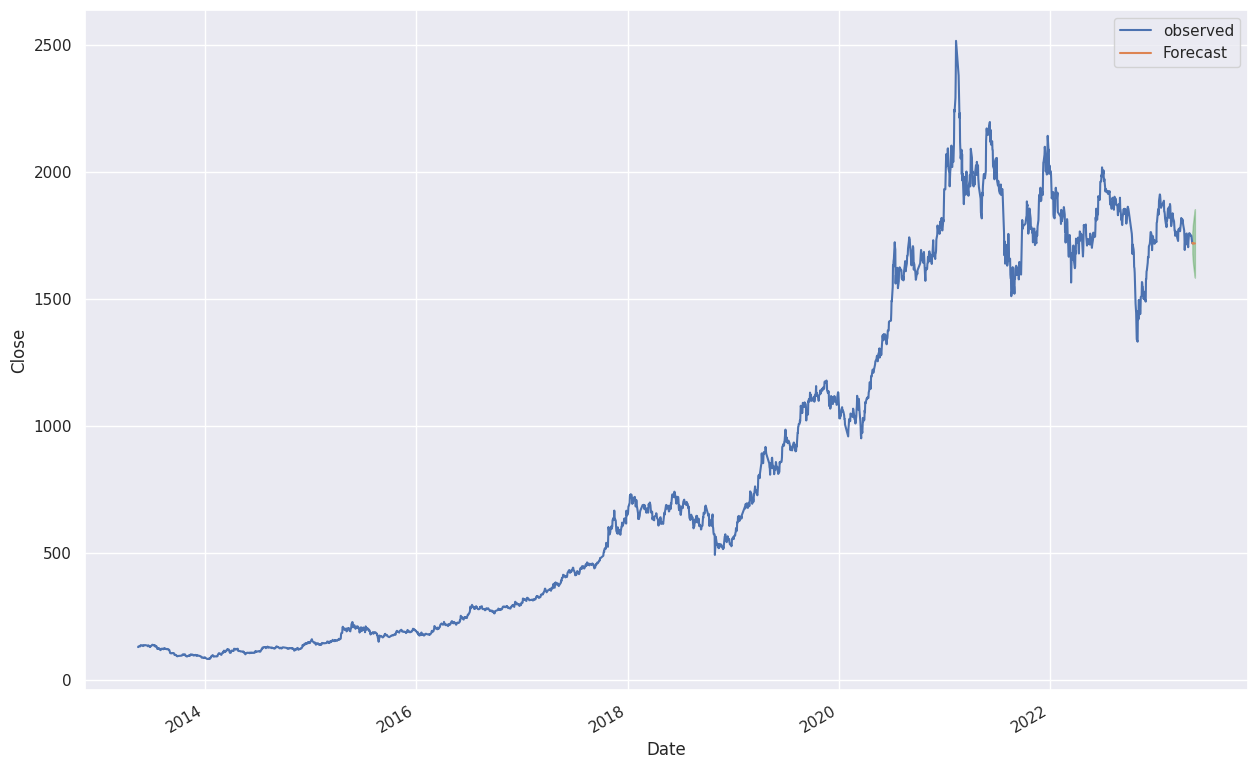

In [ ]:
ax = y.plot(label='observed', figsize=(15, 10))
y_pred_mean_dti.plot(ax=ax, label='Forecast')
ax.fill_between(y_pred.index,
y_pred.iloc[:, 0],
y_pred.iloc[:, 1], color='green', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()
plt.show()


Исходя из анализа графика, можно сделать вывод, что в будущем цены на акции компании скорее всего не будут повышаться.

## Построение моделей для прогноза по разным периодам

<Axes: title={'center': 'Цена закрытия акции'}, xlabel='Date'>

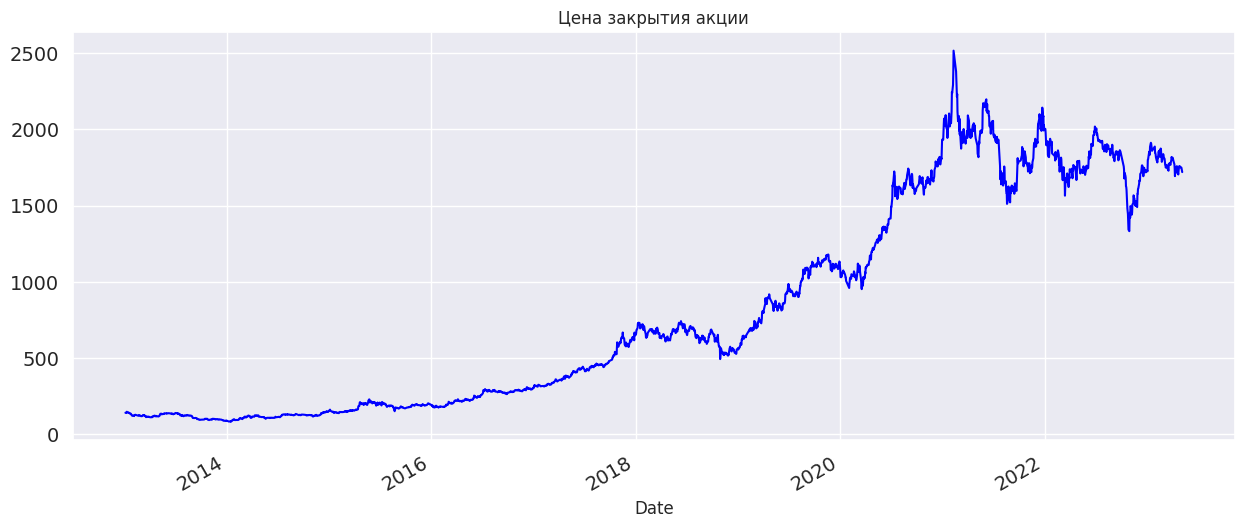

In [ ]:
df = yf.Ticker('600519.SS').history(interval = "1d", start = '2013-01-01')
df = df[['Close']]
df.Close.plot( figsize=(15,6),title= 'Цена закрытия акции', fontsize=14, color="blue")

### Требуется разделить исходные данные на 3 блока Предлагается взять такие интервалы:

1. До 2016-06-01

2. 2016-06-01 - 2020-01-01

3. 2020-01-01 - н.в.

In [ ]:
df_1 = df.index < '2016-06-01 00:00:00-04:00'
df_1 = df.loc[df_1]
df_1.shape

(828, 1)

In [ ]:
df_2 = df.query("index >= '2016-06-01 00:00:00-04:00' & index < '2020-01-01 00:00:00-04:00'")
df_2.shape

(872, 1)

In [ ]:
df_3 = df.query("index > '2020-01-01 00:00:00-04:00'")
df_3.shape

(809, 1)

### Разделим выборку на тестовую и обучающую

In [ ]:
train_1, test_1 = df_1[0:704], df_1[704:]
train_2, test_2 = df_2[0:742], df_2[742:]
train_3, test_3 = df_3[0:688], df_3[688:]

In [ ]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MAE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_1.Close, order = params)
    result_test = model_test.fit()
    if result_test.mae < best_MAE:
        best_params = params
        best_MAE = result_test.mae
        
model_test = sm.tsa.arima.ARIMA(test_1.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 1 block:', best_params, 'на train:',best_MAE, 'на test:', result_test.mae)

  0%|          | 0/250 [00:00<?, ?it/s]

Best model on 1 block: (3, 0, 5) на train: 2.132146596651886 на test: 2.7488671533761857


In [ ]:
p = range(0, 5)
d = range(0, 5)
q = range(0, 10)
pdq = list(itertools.product(p, d, q))

best_params = (0, 0, 0)
best_MAE = np.inf

for params in tqdm(pdq):
    try:
        model = sm.tsa.arima.ARIMA(train_2.Close, order=params)
        result = model.fit()
        if result.mae < best_MAE:
            best_params = params
            best_MAE = result.mae
    except:
        continue

model = sm.tsa.arima.ARIMA(test_2.Close, order=best_params)
result = model.fit()
print('Best model on 2 block:', best_params, 'MAE on train:', best_MAE, 'MAE on test:', result.mae)

  0%|          | 0/250 [00:00<?, ?it/s]

Best model on 2 block: (4, 1, 7) MAE on train: 8.131265391358152 MAE on test: 18.81789890090917


In [ ]:
p = range(0,5)
d = range(0,5)
q = range(0,10)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_MAE = np.inf

for params in tqdm(pdq):
    
    model_test = sm.tsa.arima.ARIMA(train_3.Close, order = params)
    result_test = model_test.fit()
    if result_test.mae < best_MAE:
        best_params = params
        best_MAE = result_test.mae
        
model_test = sm.tsa.arima.ARIMA(test_3.Close, order = best_params)
result_test = model_test.fit()
print('Best model on 3 block:', best_params, 'на train:',best_MAE, 'на test:', result_test.mae)

  0%|          | 0/250 [00:00<?, ?it/s]

Best model on 3 block: (3, 0, 3) на train: 26.47764874372905 на test: 19.47256573584231


Из результатов моделирования видно, что лучшая модель на первом блоке данных имеет порядок (3,0,5) и достигает MAE на тренировочной выборке в размере 2.132, а на тестовой - 2.749. 

Лучшая модель на втором блоке данных имеет порядок (4,1,7) и достигает MAE на тренировочной выборке в размере 8.131, а на тестовой - 18.817. 

Лучшая модель на третьем блоке данных имеет порядок (3,0,3) и достигает MAE на тренировочной выборке в размере 26.478, а на тестовой - 19.473.

Модель с наименьшим значением MAE на тестовой выборке является наиболее предпочтительной для прогнозирования будущих значений. Следовательно, на основе результатов моделирования можно сделать вывод, что наиболее точная модель на тестовой выборке была построена на первом блоке данных и имеет порядок (3,0,5).